In [85]:
import gurobipy as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import function_library_assignment_1 as fnc

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #filtering FutureWarnings - we don't need to worry about them in this case
#(This is run using Python 3.9)

%load_ext autoreload
%autoreload 2

plt.rcParams['font.size']=12
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] = True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4

# Read data
gen_data = fnc.read_data('gen_data')
demand = fnc.read_data('system_demand')['System Demand']
load_distribution = fnc.read_data('load_distribution')
gen_costs = fnc.read_data('gen_costs')
line_data = fnc.read_data('line_data')
branch_matrix = fnc.read_data('branch_matrix')
wind_data = fnc.read_data('wind_data')
all_bid_prices = fnc.read_data('all_bid_prices')

GC = len(gen_data.index)
GW = len(wind_data.columns)
G = GC + GW
D = len(load_distribution.index)
N = 24 # number of buses

WF_NODES = [2, 4, 6, 15, 20, 22] # zero-indexed
BESS_NODES = [2, 4, 6, 15, 20, 22] #note the nodes here are 0-indexed
B = len(BESS_NODES) # number of batteries

T = 24 # number of hours

S_BASE_MVA = 100 # base power of the network for per-unit calculations

# Define input parameters of batteries (per-unitized values for nodal power flow)
SOC_max = 1 # Maximum SOC capacity of each battery (per unit)
SOC_ini = 0 # initial SOC - will also be enforced at the end of the period
P_max_BESS = SOC_max # Maximum charging/discharging power of each battery (per unit)
eta_bess = 0.95 # charging and discharging efficiency

#This dictionary return the 0-indexed indices of generators or wind farms located at the node n

#for example, gens_map.get(0) will return the list [0] because generator 1 is placed at node 1
#gens_map.get(14) will return [4, 5] because generators 5 and 6 are at node 15

#if no generation units are located at node n, it will return an empty list

wf_df = pd.DataFrame(index=np.arange(12,18))
wf_df[['Unit #', 'Node']] = 0
wf_df['Type'] = 'WF'

for i in range(GC, G):
    wf_df.loc[i, 'Unit #'] = i + 1
    wf_df.loc[i, 'Node'] = WF_NODES[i-GC] + 1 #WF_NODES is 0-indexed, but the nodes are 1-indexed in the data

gen_nodes = gen_data[['Unit #', 'Node']].copy(deep=True)
gen_nodes['Type'] = 'CONVENTIONAL'
gen_nodes = pd.concat([gen_nodes, wf_df], ignore_index=True, axis=0)

gens_map = {}

for n in range(1, N + 1):
    gens_map[n - 1] = (gen_nodes['Unit #'][gen_nodes['Node'] == n] - 1).tolist()

bess_map = {}

for n in range(N):
    bess_map[n] = np.where(np.array(BESS_NODES) == n)[0].tolist()

load_map = {}

for n in range(1, N + 1):
    load_map[n - 1] = (load_distribution['Load #'][load_distribution['Node'] == n] - 1).tolist()

# Define the hourly load distribution
    
hourly_loads = {} #dictionary containing the hourly load distributions

for t in range(T):
    load = np.zeros(N)
    system_demand = demand[t]  # Update demand for each hour

    #Saving the load for each bus in a numpy array accounting for the system load destribution
    for n in load_distribution['Node'].unique():
        load[n-1] = load_distribution.loc[load_distribution['Node'] == n, r'% of system load'] / 100 * system_demand #load - remember that the data is not 0-indexed while the arrays are

    hourly_loads[t] = load #Save load for each hour


#ASSUMPTION: The value of the bid prices is the same for all hours
for t in range(T):
    bid_prices = np.zeros(D)

    for n in range(D):
        bid_prices[n] = all_bid_prices.loc[all_bid_prices['Load #'] == (n + 1), f't{18}'] #use the bid prices for the same hour that we used for task 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup Gurobi model (NODAL)

In [87]:
direction = gb.GRB.MAXIMIZE #Min / Max

m = gb.Model() # Create a Gurobi model  

#============= Variables =============
#NOTE: We now use per unitized values for power flows
theta = m.addVars(N, T, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="theta") #bus voltage angles
p_G = m.addVars(G, T, lb=0, ub=gb.GRB.INFINITY, name="P_G") #Note: wind farms can be curtailed AND P_min from the system should be disregarded to avoid having a mixed integer program
p_D = m.addVars(D, T, lb=0, ub=gb.GRB.INFINITY, name="P_D") #Note: demands are elastic
p_B = m.addVars(B, T, lb = -gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="P_B") #battery power (charging is positive, discharging is negative)
bess_SOC = m.addVars(B, T, lb=0, ub=SOC_max, name="BESS_SOC") #battery state of charge

#============= Objective function =============
# Set objective function (social welfare) - note that production cost of wind farms is assumed to be zero
#remember transformation back to MW from per unit values
obj = gb.quicksum(bid_prices[d] * p_D[d,t] * S_BASE_MVA for d in range(D) for t in range(T)) - gb.quicksum(gen_costs['C ($/MWh)'][k] * p_G[k,t] * S_BASE_MVA for k in range(GC) for t in range(T))
m.setObjective(obj, direction)

#Note: Each constraint will appear for each hour t

#============= Balance equation =============
m.addConstrs(gb.quicksum(p_D[d,t] for d in load_map.get(n)) 
                - gb.quicksum(p_G[g,t] for g in gens_map.get(n)) 
                + gb.quicksum(p_B[b,t] for b in bess_map.get(n)) 
                + gb.quicksum(branch_matrix[n,k] * (theta[n,t] - theta[k,t]) for k in range(N) if k != n) 
                == 0 for n in range(N) for t in range(T))

m.addConstrs(theta[0,t] == 0 for t in range(T)) #reference bus angle is 0

#============= Transmission line flow constraints =============

#Remembering that the "to" and "from" are not zero-indexed in the line data
for n in range(N):
    for k in range(n, N): #Avoid duplicates by starting the indexing of k at i
            if (n != k) and (branch_matrix[n,k] != 0):
                m.addConstrs(branch_matrix[n,k] * (theta[n,t] - theta[k,t]) <= (line_data.loc[(line_data['From'] == n + 1) & (line_data['To'] == k + 1), 'Capacity pu'].sum()) for t in range(T))
                m.addConstrs(branch_matrix[n,k] * (theta[n,t] - theta[k,t]) >= -1 * (line_data.loc[(line_data['From'] == n + 1) & (line_data['To'] == k + 1), 'Capacity pu'].sum()) for t in range(T))

#============= Generator limits and ramping constraints ============
m.addConstrs(p_G[g,t] <= (gen_data['P max MW'].iloc[g]) / S_BASE_MVA for g in range(GC) for t in range(T)) #conventinal generator upper limits

#Maximum wind power is the per-unitized output of the non-curtailed wind farm in the hour t
m.addConstrs(p_G[GC + g, t] <= wind_data.iloc[t, g] / S_BASE_MVA for g in range(GW) for t in range(T)) #wind farm generator upper limits

#Ramping constraints
m.addConstrs(p_G[g,t] - p_G[g,t-1] <= (gen_data['RU MW/h'].iloc[g]) / S_BASE_MVA for g in range(GC) for t in range(1, T)) #ramping up limitation
m.addConstrs(p_G[g,t-1] - p_G[g,t] <= (gen_data['RD MW/h'].iloc[g]) / S_BASE_MVA for g in range(GC) for t in range(1, T)) #ramping down limitation

#============= Demand limits ===============
for t in range(T):
    load = hourly_loads[t].copy()
    m.addConstrs(p_D[d,t] <= load[load != 0][d] / S_BASE_MVA for d in range(D)) #demand limits

#============= Battery limits & state of charge ==============
m.addConstrs(p_B[b,t] <= P_max_BESS for b in range(B) for t in range(T))
m.addConstrs(p_B[b,t] >= -P_max_BESS for b in range(B) for t in range(T))

# Initial state of charge for BESSs
m.addConstrs(bess_SOC[b, 0] == SOC_ini for b in range(B)) #note that SOC is handled as SOC at the START of the hour

# Final SOC equal to initial SOC
m.addConstrs(bess_SOC[b, (T - 1)] + eta_bess * p_B[b,(T - 1)] == SOC_ini for b in range(B))

#Inter-temporal SOC balance
m.addConstrs(bess_SOC[b,t] == bess_SOC[b, (t-1)] + eta_bess * p_B[b,(t-1)] for b in range(B) for t in range(1, T)) 

#============= Display and run model =============
#m.update()
#m.display()
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 4062 rows, 1704 columns and 9144 nonzeros
Model fingerprint: 0x8a68982a
Coefficient statistics:
  Matrix range     [9e-01, 2e+02]
  Objective range  [5e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 1e+01]
Presolve removed 2641 rows and 210 columns
Presolve time: 0.01s
Presolved: 1421 rows, 2375 columns, 6063 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1224    7.0653744e+05   0.000000e+00   0.000000e+00      0s

Solved in 1224 iterations and 0.02 seconds (0.02 work units)
Optimal objective  7.065374430e+05


## Analyze results

In [95]:
print_variables = False

#Print solutions
if m.status == gb.GRB.OPTIMAL:
    results = {}
    constraints = m.getConstrs()
    dual_values = [constraints[k].Pi for k in range(len(constraints))] 

    overview = pd.DataFrame(data=np.zeros(T), columns=['Hour'], dtype=int)
    overview['Maximum Demand [MWh]'] = demand.values
    overview['Load [MWh]'] = 0
    overview['Total Production [MWh]'] = 0
    overview['Wind [MWh]'] = 0
    overview['Dispatchable Production [MWh]'] = 0
    overview['BESS Charging [MWh]'] = 0
    overview['BESS Discharging [MWh]'] = 0
    overview['AVERAGE Lambda [$/MWh]'] = 0

    overview[(r'Aggregated BESS SOC [%]')] = 0.0

    #Get results for each hour
    for t in range(T):
        print('==========================================================')
        print('HOUR %d\n' % t)

        hour_results = {}

        generator_outputs = pd.DataFrame(data=np.zeros(G), columns=['p_G'])
        generator_outputs['Node'] = 0 #initialize
        generator_outputs['Dispatched Percentage'] = 0
        generator_outputs['Type'] = 'Conventional'

        load = hourly_loads[t].copy()
        load_results = pd.DataFrame(data=np.zeros(D), columns=['p_D'])
        load_results['Node'] = load_distribution['Node'].values
        load_results['Maximum Demand'] = load[load != 0]

        bess_results = pd.DataFrame(data=np.zeros(B), columns=['Charging [pu]'])
        bess_results[['Discharging [pu]', 'SOC']] = 0.0
        bess_results['Node'] = 0 #initialize
        

        theta_dict = {}

        for i in range(G):
            if print_variables: print(p_G[i,t].VarName + ": %.2f MW" % (p_G[i,t].x * S_BASE_MVA))
            generator_outputs.loc[generator_outputs.index == i, 'p_G'] = p_G[i,t].x

            if i < GC:
                generator_outputs.loc[generator_outputs.index == i, 'Node'] = gen_data.loc[gen_data.index == i, 'Node'].values #save node
                gen_limit = gen_data.loc[gen_data.index == i, 'P max MW']
                generator_outputs.loc[generator_outputs.index == i, 'Dispatched Percentage'] = (p_G[i,t].x * S_BASE_MVA / gen_limit) * 100
            else:
                generator_outputs.loc[generator_outputs.index == i, 'Node'] = WF_NODES[i - GC] + 1 #save node (from zero-indexed to 1-indexed)
                wind_limit = wind_data.iloc[t, i - GC]
                generator_outputs.loc[generator_outputs.index == i, 'Dispatched Percentage'] = (p_G[i,t].x * S_BASE_MVA / wind_limit) * 100
                generator_outputs.loc[generator_outputs.index == i, 'Type'] = 'Wind'

        for i in range(D):
            if print_variables: print(p_D[i,t].VarName + ": %.2f MW" % (p_D[i,t].x * S_BASE_MVA))
            load_results.loc[load_results.index == i, 'p_D'] = p_D[i,t].x

        for b in range(B):
            if print_variables: print(p_B[b,t].VarName + ": %.2f MW" % (p_B[b,t].x * S_BASE_MVA))
            if print_variables: print(bess_SOC[b,t].VarName + ": %.2f MWh" % (bess_SOC[b,t].x * S_BASE_MVA))
            bess_results.loc[bess_results.index == b, 'Node'] = BESS_NODES[b] + 1 #save node (from zero-indexed to 1-indexed)
            bess_results.loc[bess_results.index == b, 'SOC'] = bess_SOC[b,t].x

            if p_B[b,t].x < 0:
                bess_results.loc[bess_results.index == b, 'Discharging [pu]'] = abs(p_B[b,t].x)
            else:
                bess_results.loc[bess_results.index == b, 'Charging [pu]'] = abs(p_B[b,t].x)

        for n in range(N):
            if print_variables: print(theta[n,t].VarName + ": %.2f rad" % theta[n,t].x)
            theta_dict[n] = theta[n,t].x


        branch_flows = pd.DataFrame(columns=['From', 'To', 'Flow', 'Loading Percentage'])
        for n in range(N):
            for k in range(n, N): #Avoid duplicates by starting the indexing of k at i
                    if (n != k) and (branch_matrix[n,k] != 0):
                        flow = branch_matrix[n,k] * (theta[n,t].x - theta[k,t].x) #flow from n to k indexed by hour t and the tuple (n,k) in per unit

                        flow_limit = line_data.loc[(line_data['From'] == n + 1) & (line_data['To'] == k + 1), 'Capacity pu'].sum() #get flow limit for the branch
                        loading_percentage = (abs(flow) / flow_limit) * 100

                        new_row = {'From': [n], 'To': [k], 'Flow': [flow], 'Loading Percentage':loading_percentage}
                        branch_flows = pd.concat([branch_flows, pd.DataFrame(new_row)], axis=0)
        
        lambda_hour = np.array(dual_values[(0 + t * N) : (N + t * N)]) / S_BASE_MVA #due to per-unitization, they are 100 (S_BASE_MVA) times larger than the actual values

        hour_results['lambda'] = lambda_hour.copy() #dual values for the balance equations (the first N x T constraints)
        hour_results['gen'] = generator_outputs.copy(deep=True)
        hour_results['demand'] = load_results.copy(deep=True)
        hour_results['bess'] = bess_results.copy(deep=True)
        hour_results['theta'] = theta_dict.copy()
        hour_results['flow'] = branch_flows.reset_index(drop=True).copy(deep=True)
        
        results[t] = hour_results.copy()

        # Results for the overview - used for plotting
        sum_gen = sum(p_G[g,t].x for g in range(GC)) * S_BASE_MVA
        sum_wind = sum(p_G[g,t].x for g in range(GC, GC + GW))  * S_BASE_MVA
        sum_production = sum(p_G[g,t].x for g in range(G))  * S_BASE_MVA
        sum_load = sum(p_D[d,t].x for d in range(D)) * S_BASE_MVA

        overview.loc[overview.index == t, 'Hour'] = t + 1
        overview.loc[overview.index == t, 'Load [MWh]'] = sum_load
        overview.loc[overview.index == t, 'Total Production [MWh]'] = sum_production
        overview.loc[overview.index == t, 'Wind [MWh]'] = sum_wind
        overview.loc[overview.index == t, 'Dispatchable Production [MWh]'] = sum_gen
        overview.loc[overview.index == t, 'AVERAGE Lambda [$/MWh]'] = np.mean(lambda_hour)

        sum_bess_charge = sum(p_B[b,t].x for b in range(B)) * S_BASE_MVA
        agg_bess_SOC = sum(bess_SOC[b,t].x for b in range(B)) / (B * SOC_max) #aggregated SOC for all batteries

        overview.loc[overview.index == t, (r'Aggregated BESS SOC [%]')] = agg_bess_SOC * 100

        if sum_bess_charge < 0:
            overview.loc[overview.index == t, 'BESS Discharging [MWh]'] = abs(sum_bess_charge)
        else:
            overview.loc[overview.index == t, 'BESS Charging [MWh]'] = abs(sum_bess_charge)

        #print('-----------------------------------------------')
        print("Total load: %.1f MWh" % sum_load)
        print("Total generation: %.1f MWh" % sum_production)
        print("BESS charge: %.1f MWh" % sum_bess_charge)
        print("Lambdas ($/MWh)", lambda_hour)


    print('==========================================================')
    print("Optimal objective value: %.2f $" % m.objVal)

    results['overview'] = overview.copy(deep=True)

else:
    print("Optimization was not successful.")     

overview

HOUR 0

Total load: 1775.8 MWh
Total generation: 1866.4 MWh
BESS charge: 90.6 MWh
Lambdas ($/MWh) [ 5.47        5.47        5.47        5.47        5.47        5.47
  6.00498714 13.26443044 13.26526333 13.26526333 13.26526333 13.26526333
 13.26526333 13.32464561 13.32464561 13.67239791 13.67239791 13.67239791
 13.67239791 13.67239791 13.3423339  13.3423339  13.2976661  13.24588008]
HOUR 1

Total load: 1669.8 MWh
Total generation: 1679.2 MWh
BESS charge: 9.4 MWh
Lambdas ($/MWh) [ 5.47        5.47        5.47        5.47        5.47        5.47
  6.00423153 13.31915879 13.32       13.32       13.32       13.32
 13.32       13.37489379 13.37489379 13.72612166 13.72612166 13.72612166
 13.72612166 13.72612166 13.39126602 13.39126602 13.3461518  13.2938482 ]
HOUR 2

Total load: 1590.3 MWh
Total generation: 1500.8 MWh
BESS charge: -89.5 MWh
Lambdas ($/MWh) [ 5.47        5.47        5.47        5.47        5.47        5.47
  6.02903551 11.5226301  11.52319805 11.52319805 11.52319805 11.5231980

,Hour,Maximum Demand [MWh],Load [MWh],Total Production [MWh],Wind [MWh],Dispatchable Production [MWh],BESS Charging [MWh],BESS Discharging [MWh],AVERAGE Lambda [$/MWh],Aggregated BESS SOC [%]
0,1,1775.835,1775.835000,1866.442579,1166.442579,700.000000,90.607579,0.000000,11.110635,0.000000
1,2,1669.815,1669.815000,1679.207421,1150.804786,528.402635,9.392421,0.000000,11.147763,14.346200
2,3,1590.300,1590.300000,1500.826316,1163.043655,337.782661,0.000000,89.473684,9.928965,15.833333
3,4,1563.795,1563.795000,1779.584474,1163.823527,615.760947,215.789474,0.000000,11.259939,1.666667
4,5,1563.795,1563.795000,1702.833173,1160.086964,542.746209,139.038173,0.000000,11.355689,35.833333
5,6,1590.300,1590.300000,1856.524985,1156.524985,700.000000,266.224985,0.000000,11.499504,57.847711
6,7,1961.370,1922.432218,1882.213950,1182.213950,700.000000,0.000000,40.218269,11.480712,100.000000
7,8,2279.430,1974.269956,1902.197011,1202.197011,700.000000,0.000000,72.072945,11.480712,93.632107
8,9,2517.975,2110.063050,1987.794077,1207.324249,780.469827,0.000000,122.268973,11.351765,82.220558
9,10,2544.480,2132.274240,2018.244482,1220.993081,797.251401,0.000000,114.029758,11.609658,62.861304


In [94]:
results[17]['flow']

,From,To,Flow,Loading Percentage
0,0,1,0.301826,17.247190
1,0,2,0.237070,13.546831
2,0,4,-0.026085,0.745296
3,1,3,1.025381,58.593190
4,1,5,0.796445,45.511142
5,2,8,1.002049,57.259918
6,2,23,-0.793737,19.843428
7,3,8,0.336251,19.214333
8,4,9,1.484019,42.400541
9,5,9,-0.475795,27.188286


## Visualization

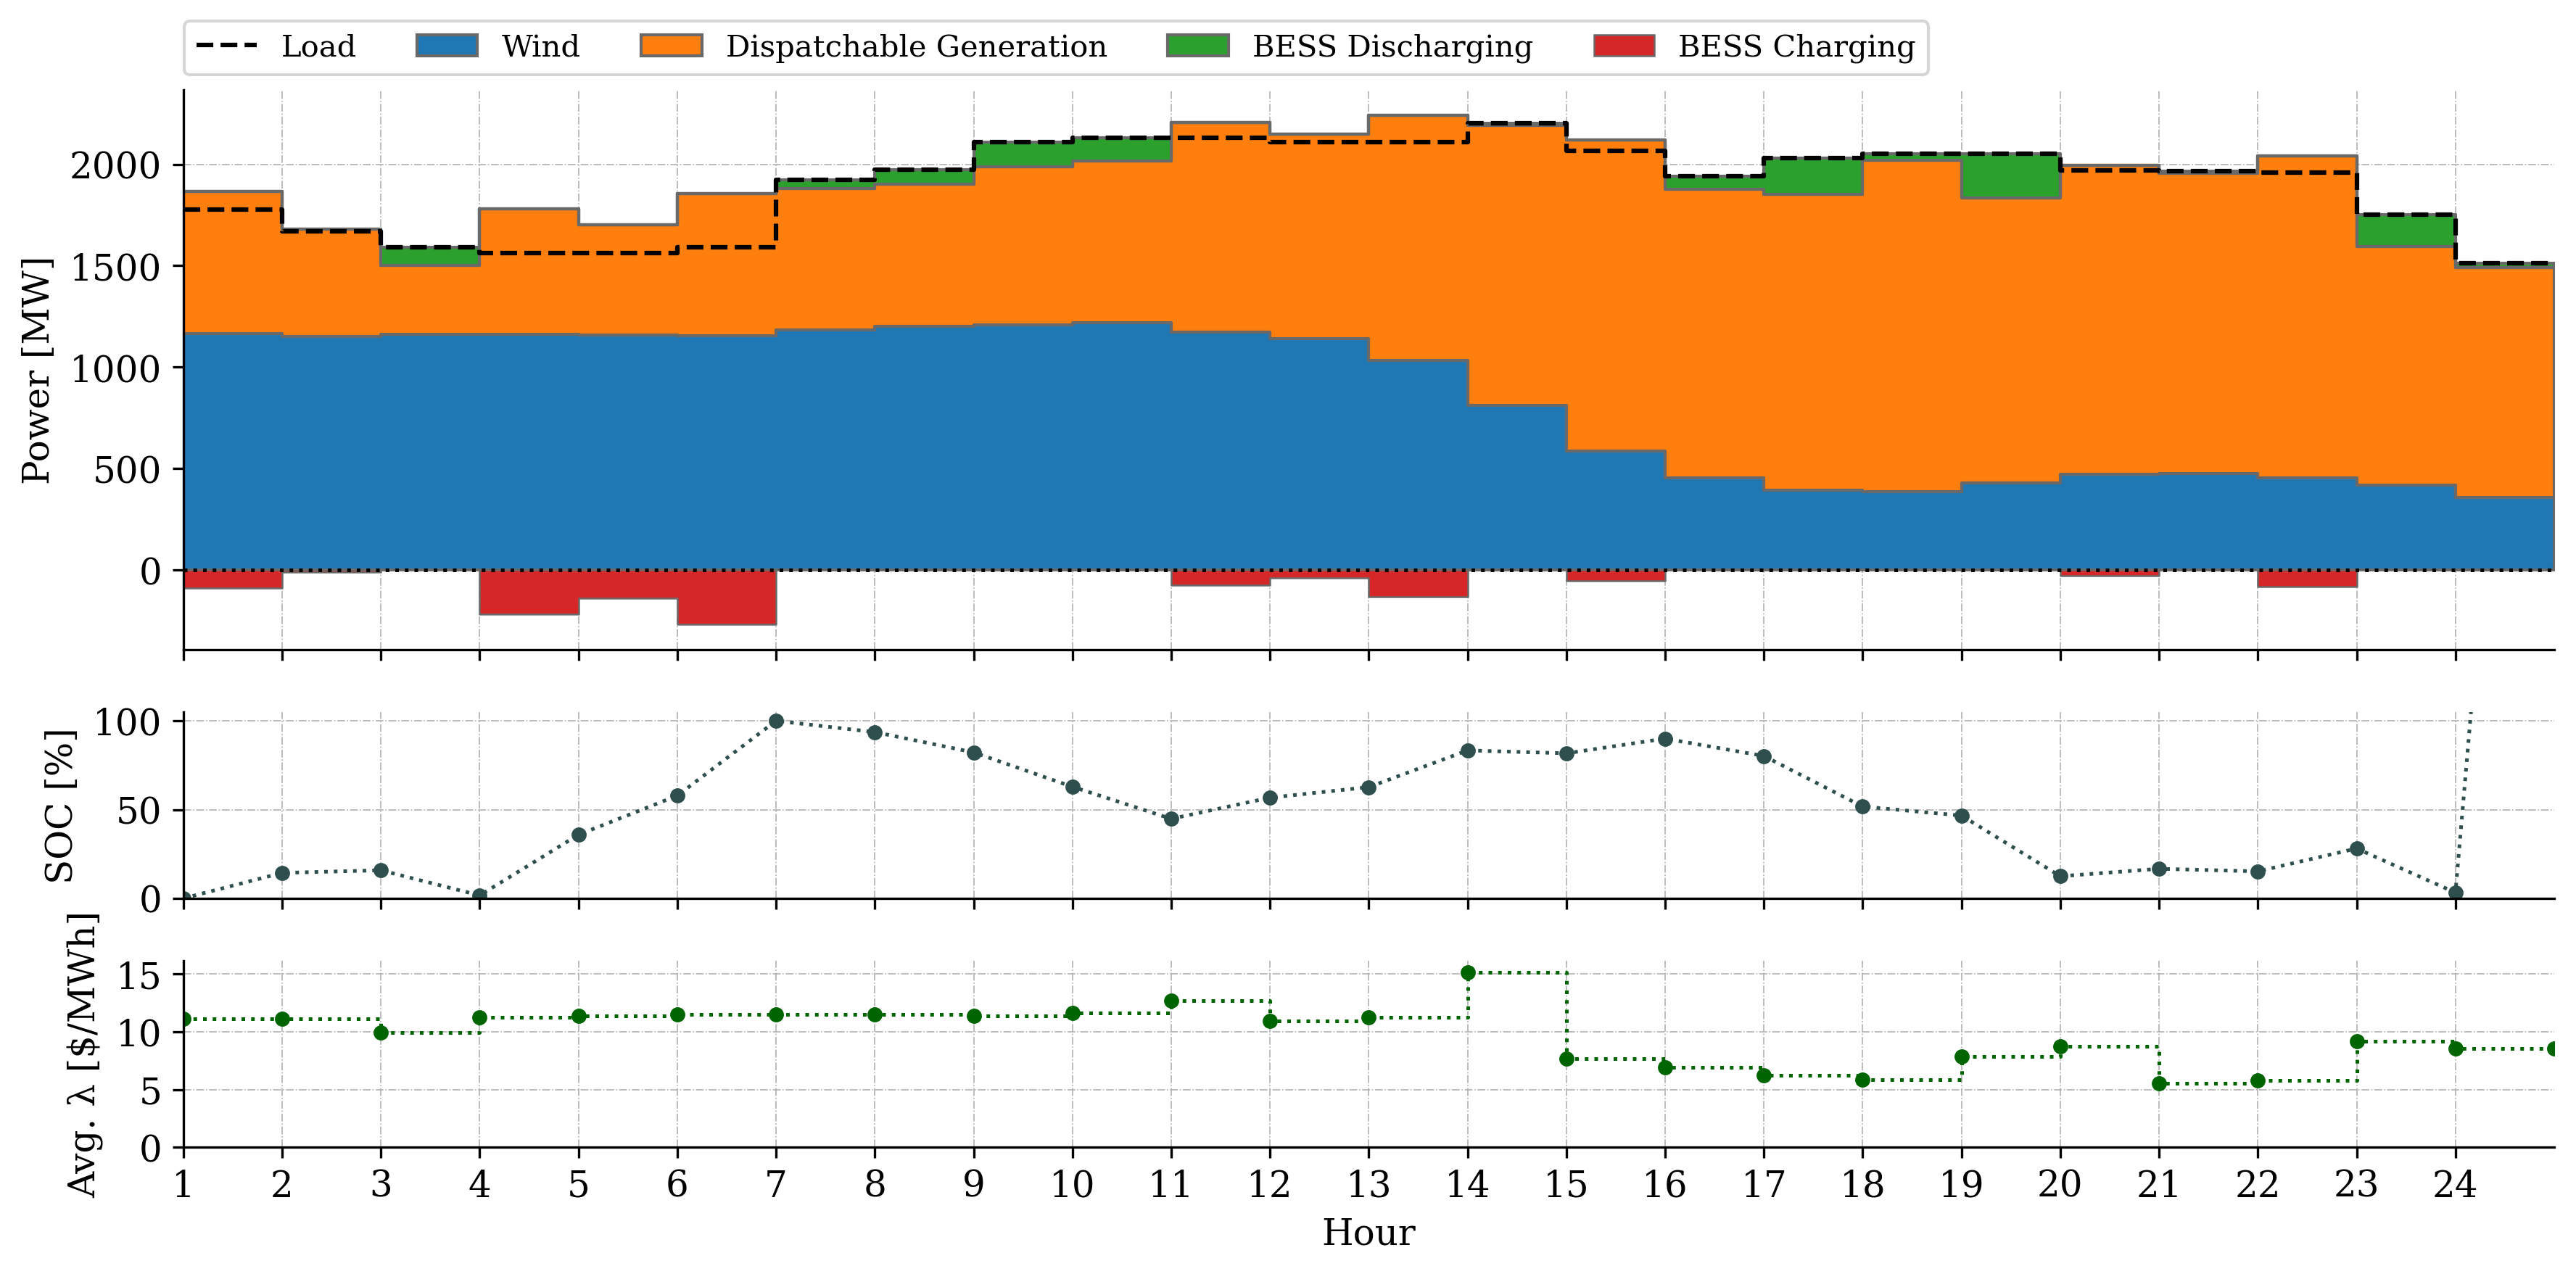

In [98]:
fig, ax = plt.subplots(3,1,sharex=True,figsize=( 12 , 6 ) , dpi=300, gridspec_kw={'height_ratios': [3, 1, 1]}) # Create the figure

df = results.get('overview')

#make a final dummy row to include the final hour in the plot
df = df.append(df.iloc[-1], ignore_index=True)
df.iloc[-1, 0] = T + 1
df.iloc[-1, -1] = (df.iloc[-2, -1] + eta_bess * df.iloc[-2, -3] / (B * SOC_max)) * 100 #update the SOC to the final SOC

#Plotting
ax[0].step(df.index, df['Load [MWh]'], where='post', color='black', label='Load', linestyle='--')

ax[0].stackplot(df.index, df[['Wind [MWh]', 'Dispatchable Production [MWh]', 'BESS Discharging [MWh]']].T, 
                    step='post', edgecolor='dimgrey', labels=['Wind', 'Dispatchable Generation', 'BESS Discharging'], colors=['tab:blue', 'tab:orange', 'tab:green'])

ax[0].stackplot(df.index, -1 * df['BESS Charging [MWh]'].T, step='post', edgecolor='dimgrey', labels=['BESS Charging'], linewidth=0.6, colors=['tab:red'])

ax[0].axhline(0, color='black', linewidth=1.2, linestyle=':')

ax[0].set_ylabel('Power [MW]')
ax[0].legend(loc='upper left', bbox_to_anchor=(-0.006, 1.15),ncol=5, fontsize=10)

ax[1].plot(df.index, df[r'Aggregated BESS SOC [%]'], linestyle=':', color='darkslategrey', linewidth=1.2)
ax[1].plot(df.index, df[r'Aggregated BESS SOC [%]'], linestyle='', marker='o', markersize=4, color='darkslategrey')
ax[1].set_ylabel('SOC [%]')
ax[1].set_ylim([0,105])
ax[1].set_yticks(np.arange(0, 105, 50))

ax[2].step(df.index, df['AVERAGE Lambda [$/MWh]'], linestyle=':', color='darkgreen', linewidth=1.2, where='post')
ax[2].plot(df.index, df['AVERAGE Lambda [$/MWh]'], linestyle='', marker='o', markersize=4, color='darkgreen')
ax[2].set_ylabel('Avg. \u03bb [$/MWh]')
ax[2].set_ylim([0, max(df['AVERAGE Lambda [$/MWh]']) + 1])
ax[2].set_yticks(np.arange(0, max(df['AVERAGE Lambda [$/MWh]']) + 1, 5))

ax[1].margins(x=0)
ax[2].set_xticks(np.arange(0,T))
ax[2].set_xticklabels(np.arange(1,T+1))
ax[2].set_xlabel('Hour')
ax[0].set_axisbelow(True)
ax[1].set_axisbelow(True)
ax[2].set_axisbelow(True)

fig.tight_layout() # reduces white space around figures
#plt.savefig('Figures/task_4_multihour_market_clearing.png',bbox_inches='tight')

plt.show()